### Re-building the legacy propsensity model  (Jul'17)

I am using the same variables prepared for the 2016 analysis (excluded some variables that weren't powerful)   
The purpose of this rebuild is to;  
- move the analysis to Python  
- use the techniques and evaluation learnt from the Data Science course
- consider how the model might perform without Mosaic

In [1]:
import pypyodbc , pandas as pd ## I ran "pip install pypyodbc" from the command line 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
%matplotlib inline 

pd.options.mode.chained_assignment = None  # default='warn', this turns off warnings about slicing data 

### Importing data sample of deceased supporters which outcome - left a legacy or not.

In [2]:
# Importing data
connection = pypyodbc.connect('Driver={SQL Server};'
                              'Server= INSERT SERVER NAME;'
                              'Database = analystdata;'
                              'Trusted_Connection=yes;')
cursor = connection.cursor()

In [3]:
## analysing deceased supporters, who did/ didnt leave a legacy?
SQLCommand = ("select * from analystData.dbo.k049_legacyModel where deceasedFlag =1") 
cursor.execute(SQLCommand) 

columns = [column[0] for column in cursor.description]
data= cursor.fetchall()

for i in range(0,len(data)):
    data[i]=tuple(data[i])
    
df_orig = pd.DataFrame(data, columns = columns)
connection.close()

In [4]:
df_orig.head(1)
# pd.crosstab(
df_orig['idcontact'].groupby(df_orig.legatorflag).count()

legatorflag
0    76946
1     1325
Name: idcontact, dtype: int64

**1.7% of supporters leave a legacy **

In [4]:
#refining the dataset for modelling 
model = df_orig.drop(['idcontact','contactreference','mosaicname','deceaseddate','age','knownlegatorflag','postcode',
                     'firstpaymentdate','lastpaymentdate','pledgeregistrationdate', 'deceasedflag',
                      'lastpaymentmethod',
                     'dmsegment'], # This would be the latest dmsegment rather than the dmsegment whilst a living supporter
                     axis=1) #lastpaymentmethod not populated from sql

## How many nulls are there? What are the datatypes?
for x in model.columns.values:
    print (x,# print variable name 
           ', Type:', model[x].dtypes, #print data type 
           ', Nulls:', model[x].isnull().sum()) # print number of nulls 

title , Type: object , Nulls: 0
gender , Type: object , Nulls: 0
ukregion , Type: object , Nulls: 121
mosaic , Type: object , Nulls: 1221
legatorflag , Type: int64 , Nulls: 0
legmarketingflag , Type: int64 , Nulls: 0
pledgestatus , Type: object , Nulls: 0
ltv , Type: object , Nulls: 0
giftaidflag , Type: int64 , Nulls: 0
emerdonorcount , Type: int64 , Nulls: 0
bankoneoffcount , Type: int64 , Nulls: 0
bankpledgecount , Type: int64 , Nulls: 0
dmflag , Type: int64 , Nulls: 0
campaignerflag , Type: int64 , Nulls: 0
traderflag , Type: int64 , Nulls: 0
landlineflag , Type: int64 , Nulls: 0
mobilephoneflag , Type: int64 , Nulls: 0


**Cleaning up the data ** 

In [5]:
model['ltv'] = model['ltv'].astype(float)

for col in ['emerdonorcount','bankoneoffcount','bankpledgecount','ltv']: 
    model[col] = model[col].fillna(0) 


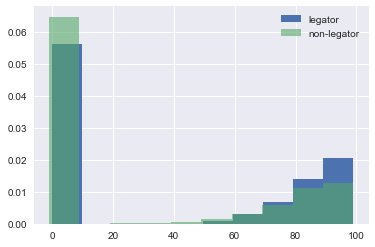

In [22]:
plt.hist(df_orig['age'][df_orig.legatorflag==1][df_orig.age <100], label = 'legator', normed=True)
plt.hist(df_orig['age'][df_orig.legatorflag==0][df_orig.age <100], label = 'non-legator',alpha=0.6, normed=True)
plt.legend()
plt.show()

# sns.factorplot('age', 'legatorflag', data=model, kind ='bar')

Legators tend to live a little longer...  
It occured to me that someones age at death can't be used to predict the likelihood of leaving a legacy (gone back and dropped age from the model dataframe)

In [ ]:
sns.factorplot('mosaic', col='legatorflag', data=model[model.legatorflag==1], 
               kind='count', col_wrap=1,sharey=False, size = 3, aspect =5)

sns.factorplot('mosaic', col='legatorflag', data=model[model.legatorflag==0], 
               kind='count', col_wrap=1,sharey=False, size = 3, aspect =5)


Cursory glance at the distribution of **mosaic** across legators and non-legators doesn't identify any huge variances.  The blue section appears to contain fewer legators compared to non-legators. 

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


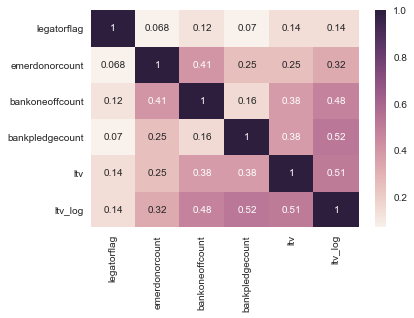

In [82]:
##Correlation of continious variables.
model['ltv_log'] = np.log(model.ltv) 
sns.heatmap(model[['legatorflag','emerdonorcount','bankoneoffcount','bankpledgecount','ltv','ltv_log']].corr(),annot=True) 


The data set is largely categorical, except for LTV, emerdonorcount, bankoneoffcount & bankpledgecount  

There's **very little correlation between the continuous predictors ** and legatorflag - LTV is correlated the most, with 0.14! Logging the LTV doesn't effect the correlation.
There's some evidence of collinearity between bankoneoffcount and emercount, and LTV and bank one-off and pledge counts.

In [83]:
model[['emerdonorcount','bankoneoffcount','bankpledgecount','ltv']][model.legatorflag==1].describe()

,emerdonorcount,bankoneoffcount,bankpledgecount,ltv
count,1325.000000,1325.000000,1325.000000,1325.000000
mean,5.016604,16.775094,38.886038,1225.270430
std,10.000893,22.101028,67.652791,3211.031039
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.000000
50%,2.000000,9.000000,0.000000,454.000000
75%,7.000000,24.000000,58.000000,1249.550000
max,124.000000,191.000000,422.000000,57682.210000


In [21]:
model[['emerdonorcount','bankoneoffcount','bankpledgecount','ltv']][model.legatorflag==0].describe()

,emerdonorcount,bankoneoffcount,bankpledgecount,ltv
count,76946.000000,76946.00000,76946.000000,76946.000000
mean,1.688496,5.21840,15.839966,239.200829
std,6.220252,11.80262,42.067317,778.212741
min,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,20.000000
75%,1.000000,4.00000,0.000000,210.000000
max,177.000000,284.00000,525.000000,53207.150000


However, if you compare the statistical summaries of the variables, the means and distributions do vary quite considerably between legators and non-legators. For instance, the average LTV for a legator is £1,225 compared to £239 for a non-legator.  The distribution confirmed below in a box plot... 

(0, 5000)

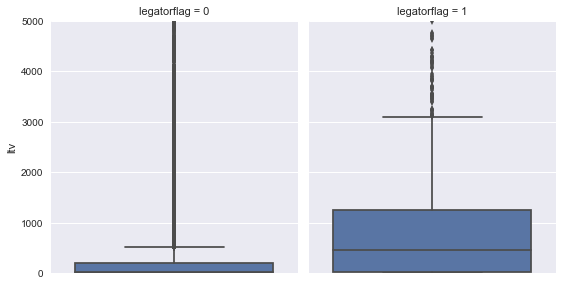

In [48]:
## set Y limit to £5000 to highlight the difference in LTV distribution between legators (green) and non-legators (blue)
# sns.boxplot(x='legatorflag',y='ltv',data= model[model.ltv<5000])
g= sns.factorplot(y='ltv', kind='box', data=model,col='legatorflag',)
axes = g.axes
axes[0,0].set_ylim(0,5000)

** Creating dummies **  
For categorical variables; title, gender, pledgestatus, mosaic, ukregion, dmsegment

In [6]:
##Grouping titles into a more manageable number, classified those with less than 100 obs as Other.
titles_to_keep = ['Mr','Mrs','Miss','Ms', 'Dr','Mr & Mrs','Revd']

def titles(t):
    if t in titles_to_keep:
        return t
    else:
        return 'Other'

model['titlegrp'] = model.title.apply(titles)

#applying dummies to the new field
title = pd.get_dummies(model.titlegrp)
title.columns = ['title_' + str(i) for i in title.columns]
title.drop('title_Other', inplace=True, axis=1) # dropping 1 dummy. 

## adding to the model dataframe
model = model.join(title)
model.drop(['titlegrp','title'],inplace=True,axis=1)

In [7]:
#Pledge status dummies 
model.pledgestatus.drop_duplicates()

0        No record
1         Declined
20         Enquiry
131        Pledged
13922     Intender
Name: pledgestatus, dtype: object

In [8]:
pledge = pd.get_dummies(model.pledgestatus) # sib_1 to 8 
pledge.columns = ['pledge_' + str(i) for i in pledge.columns]

pledge.drop('pledge_No record',inplace=True,axis=1)
model = model.join(pledge)

model.drop('pledgestatus',inplace=True, axis=1)

In [9]:
## Uk region dummies 
## NB ukregion includes 122 nulls, a dummy variable is NOT created for these, so I don't think I need to drop any other dummies.

model.ukregion.drop_duplicates() 

0                      East Anglia
1                       South West
2                       South East
3                         Scotland
4                            Wales
14                      North West
17      London & Adjacent Counties
19                        Midlands
22                      North East
40                Northern Ireland
364                           None
1269               Channel Islands
Name: ukregion, dtype: object

In [10]:
ukregion = pd.get_dummies(model.ukregion)
ukregion.columns = ['region_' + str(i) for i in ukregion.columns]
ukregion.head(1)

,region_Channel Islands,region_East Anglia,region_London & Adjacent Counties,region_Midlands,region_North East,region_North West,region_Northern Ireland,region_Scotland,region_South East,region_South West,region_Wales
0,0,1,0,0,0,0,0,0,0,0,0


In [11]:
model = model.join(ukregion)
model.drop('ukregion', inplace=True, axis=1)

In [12]:
#gender dummy
model['is_male'] = model.gender.apply(lambda x: 1 if x == 'Male' else 0)
model.drop('gender', inplace=True, axis=1)

In [13]:
# Mosaic dummies 
# Grouping mosaic by the alpha character
model['mosaicgrp'] = model.mosaic.str[0]
mosaic = pd.get_dummies(model.mosaicgrp)
mosaic.columns = ['mosaic_' + str(i) for i in mosaic.columns]
model = model.join(mosaic)

# DM segment is captured at the end of the supporters journey and not reflective of a marketing selection 
# model['dmsegmentgrp'] = model.dmsegment.str[0]
# dmsegment = pd.get_dummies(model.dmsegmentgrp) 
# dmsegment.columns = ['dmsegment_' + str(i) for i in dmsegment.columns]
# model = model.join(dmsegment)

In [14]:
# Removing fields that have been replaced by dummies
model.drop(['mosaic','mosaicgrp'],inplace=True, axis=1)

In [ ]:
# example of filling nulls with an average
# titanic['Age'] = titanic.groupby(["Sex", 'Pclass']).Age.transform(lambda x: x.fillna(x.mean()))

In [15]:
model.shape

(78271, 50)

**There is very limited correlation (<10%) between each of the predictors and the legatorflag.**  
Therefore my expectation is that the models ability to identify future legators is very low - but given the purpose of this model (to target supporters more likely to leave a legacy), the model should focus on minimising the **True Negatives** - this is the group that are predicted as not legator, but they actually do leave a legacy.

In [16]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(model, test_size = 0.2, randomstate = 0 )#random state sets a random seed so 
                                                                        # if this code were re-run the train/test split would be 
                                                                        # cut randomly in the same place.

** Fitting a logistic regression model ** 

In [18]:
X= train.ix[:,1:50]#.drop('ltv_log',axis=1) # capturing everything except the outcome in column 0.
y = train[['legatorflag']]

print(lm.fit(X, y))

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


** Calculating the p-values **  

In [19]:
# Getting P-Values for each feature
from sklearn.feature_selection import chi2
scores, pvalues = chi2(X, y)


d = []
for n in range(48):
    d.append({'Variable': X.columns[n], 'pvalue': pvalues[n]})

pd.options.display.float_format = '{:f}'.format # removing scientific notation
df_p= pd.DataFrame(d)


# for n in range(49): # alternative just printing out the rows.
#         print (X.columns[n],':  ',pvalues[n])

# keeping a list of significant variables
sig = df_p[df_p.pvalue < 0.05]

# displaying all variables
df_p.sort_values('pvalue')

,Variable,pvalue
1,ltv,0.000000
3,emerdonorcount,0.000000
4,bankoneoffcount,0.000000
5,bankpledgecount,0.000000
21,pledge_Pledged,0.000000
2,giftaidflag,0.000000
12,title_Miss,0.000000
6,dmflag,0.000000
13,title_Mr,0.000000
0,legmarketingflag,0.000002


** Calculating the Information Value for categorical data ** 

In [27]:
# defining a function 
def IV(feature, outcome, data):
    #d - dist, 1/0= legate/dnl, 1/0 = feature true or false 
    d11= data.iloc[:,0][(data[feature]==1) & (data[outcome]==1) ].count()/ data.iloc[:,0][data[outcome]==1].count()
    d10= data.iloc[:,0][(data[feature]==0) & (data[outcome]==1) ].count()/ data.iloc[:,0][data[outcome]==1].count()

    d01=data.iloc[:,0][(data[feature]==1) & (data[outcome]==0) ].count()/ data.iloc[:,0][data[outcome]==0].count()
    d00=data.iloc[:,0][(data[feature]==0) & (data[outcome]==0) ].count()/ data.iloc[:,0][data[outcome]==0].count()
    
    woe_true = np.log(d10/d00)
    woe_false = np.log(d11/d01)
    dist_true = d10-d00
    dist_false = d11-d01
    IV = woe_true * dist_true + woe_false * dist_false
    if IV > 0.3:
        status = 'strong'
    elif IV >=0.1:
        status ='medium'
    elif IV >=0.02:
        status = 'weak'
    else:
        status ='unpredictive'
            
    return IV #print(feature, ':',status, ":", IV ) # uncomment to print out all values in for loop below:

# for f in X[sig.Variable]:
#     IV(f,'legatorflag',train)

In [ ]:
## Calculating Information Value for significant variables.
i = []
for var in sig.Variable:
    i.append({'Variable': X[var].name, 
              'IV': IV(var,'legatorflag',train)})

df_i= pd.DataFrame(i)

predictive = df_i[(df_i['IV']>=0.02)] ## keeping anything that is weak to strong 

In [40]:
##shortlist of predictive and statistically significant features
predictive
# df_i.sort_values('IV')

,IV,Variable
17,0.004065,mosaic_A
19,0.005676,mosaic_J
15,0.006734,region_South West
8,0.009184,title_Dr
11,0.011345,title_Mr & Mrs
14,0.012074,region_Northern Ireland
12,0.013234,pledge_Enquiry
21,0.015056,mosaic_M
18,0.016726,mosaic_I
7,0.023845,mobilephoneflag


nb IV is used to check predictiveness of binned/ binary variables.  Hence why it creates "infinite" for the continuous variables.

** Coefficients **   
Rebuilding the model using **only significant & predictive** variables and adding **regularisation** with cross validation and C value.  
Iterated through the model fit code to test excluding some features and noting the effect on the auc.  See the spreadsheet in the working file folder of K049 for history.  

The final model includes all features except "is_male" and "mosaic_I" - in case there is any regulatory concern about using this information for marketing purposes. Excluding Mosaic does not effect the models performance.

In [32]:
X=  train[predictive.Variable].drop(['is_male','mosaic_K'], axis=1) #,'bankpledgecount','bankoneoffcount','emerdonorcount',
y = train.legatorflag

In [33]:
from sklearn import grid_search  #cross_validation

gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], #smaller values specify stronger regularization
                'class_weight': [None, 'balanced']}, #The “balanced” mode uses the values of y to automatically adjust weights 
                                                     #proportional to class frequencies in the input data
    cv=10, #cross_validation.KFold(n=len(train), n_folds=10),
    scoring='roc_auc')

gs.fit(X, y)
gs.grid_scores_ # mean is returning the average AUC for the k-folds.


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[mean: 0.75271, std: 0.01751, params: {'C': 100000, 'class_weight': None},
 mean: 0.77226, std: 0.01810, params: {'C': 100000, 'class_weight': 'balanced'},
 mean: 0.75277, std: 0.01739, params: {'C': 10000, 'class_weight': None},
 mean: 0.77227, std: 0.01813, params: {'C': 10000, 'class_weight': 'balanced'},
 mean: 0.75235, std: 0.01760, params: {'C': 1000, 'class_weight': None},
 mean: 0.77230, std: 0.01816, params: {'C': 1000, 'class_weight': 'balanced'},
 mean: 0.75248, std: 0.01759, params: {'C': 100, 'class_weight': None},
 mean: 0.77228, std: 0.01814, params: {'C': 100, 'class_weight': 'balanced'},
 mean: 0.75311, std: 0.01732, params: {'C': 10, 'class_weight': None},
 mean: 0.77228, std: 0.01815, params: {'C': 10, 'class_weight': 'balanced'},
 mean: 0.75367, std: 0.01777, params: {'C': 1, 'class_weight': None},
 mean: 0.77229, std: 0.01832, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.76188, std: 0.01648, params: {'C': 0.1, 'class_weight': None},
 mean: 0.77286, std: 0

In [34]:
print (gs.best_estimator_)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [35]:
## Applying predicted probability and predicted legacy class to the test data 
#gs holds the estimator with the best parameters
from sklearn.metrics import (roc_curve, roc_auc_score,)

test['prob_leg'] = gs.predict_proba(test[X.columns])[:,1] 
test['prob_nleg'] = gs.predict_proba(test[X.columns])[:,0] 
test['pred'] = gs.predict(test[X.columns]) 


print('train auc', roc_auc_score(train.legatorflag, gs.predict(X)))
print('test auc', roc_auc_score(test.legatorflag, test.pred))

train auc 0.710651445595
test auc 0.720833530223


The test "area under the curve" confirms that the model performs equally well on unseen data.  

In [36]:
##Creating a dataframe to show coefficients, odds and probabilities 
d = []
for n in range(len(X.columns)):
    d.append({'Variable': X.columns[n], 
              'coefs/log odds': gs.best_estimator_.coef_.item(n), #lm.coef_.item(n),
              #'odds':np.exp(lm.coef_.item(n)),
              #'probability if X=1':np.exp(lm.intercept_.item(0)+lm.coef_.item(n)*1)/(1+np.exp(lm.intercept_.item(0)+lm.coef_.item(n)*1)),

             })

pd.options.display.float_format = '{:f}'.format # removing scientific notation
df_c= pd.DataFrame(d)
print ('Intercept: ',gs.best_estimator_.intercept_)
df_c

Intercept:  [-0.37783958]


,Variable,coefs/log odds
0,legmarketingflag,-0.423685
1,ltv,0.000565
2,giftaidflag,0.177609
3,emerdonorcount,0.005600
4,bankoneoffcount,0.030020
5,bankpledgecount,0.001520
6,dmflag,-0.014622
7,mobilephoneflag,-0.224444
8,title_Miss,0.385525
9,title_Mr,-0.288376


The coefficients above are expressed in Log Odds.  Each unit increase in X (predictor) results in a change to the log odds by the value of the coefficient. If the coefficient is positive then increasing X will result in an increasing probability, if the coefficient is negative then increasing X will result in a decreasing p(X).  

If the coefficient for title_Miss is 0.762626 - the value is positive so if you are a Miss then the probability of legating will increase; title_Miss is a binary 1 or 0 flag, if you are a Miss the log odds of leaving a legacy increase by 0.76.

Converting odds to probability  = p(X)/ 1-p(X)

Probability of leaving a legacy if you are a Miss =   
(this is for illustration only, as the coefficient for Miss must be used in the context of all other coefficients)   
p(Legacy) = exp(intercept+coef x 1)   / 1+exp(intercept+coef x 1)  
        
p(Legacy) where *Miss =1*  
= exp(-4.48357778 + 0.762626 x 1)/1+exp(-4.48357778 + 0.762626 x 1)   
= 0.023639  
= **2% chance ** that the supporter will leave a legacy.

p(Legacy) where *Miss =0*  
= exp(-4.48357778 + 0.762626 x 0)/1+exp(-4.48357778 + 0.762626 x 0)   
= 0.011166831  
= ** 1% chance ** that the supporter will leave a legacy.


*NB these notes were written on the first iteration of the model/ features, so the coeficients will have changed. *

The **pledged** flag has the most sizeable and positive effect on the likelihood of legacy with a log odds of 3.46, after following the above formula this converts to 26% chance of leaving a legacy (with all other variables considered).  The  **Enquiry** status has log odds of 0.95 which broadly doubles the chance of leaving a legacy from 1.12% to 2.84%.  

The statistically significant **Mosaic groups (I,K & M)** have a negative impact on the probability.  I = Family Basics, K = Municipal Challenge, L = Vintage Value (Elderly renters, social housing etc), nb these groups are all "not in target".   It also makes sense that the groups with a negative relationship with legacy giving are the ones which are significant, because the bulk of supporters don't leave a legacy and therefore the relationship is easier to prove.  NB I & M have since be removed as they aren't predictive. 

** ROC ** 

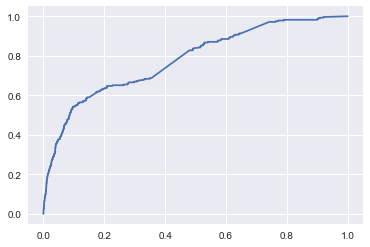

In [37]:
probas = gs.predict_proba(test[X.columns]) ## probability estimates (true and false) applied to the test data.

plt.plot(roc_curve(test.legatorflag, probas[:,1])[0], roc_curve(test.legatorflag, probas[:,1])[1])

** Default Confusion Matrix (threshold at 0.5)**  

|Threshold 	|fpr| 	tpr|
|---|---|---|
|0.501|	0.147|	0.563|  

The 0.5 threshold captures 14.7% of false positives and 56.3% of legators - at this threshold we are capturing too few of the legators.  

As the threshold is lowered the accuracy will drop too - but in this context it is better to contact false positives than not contact future legators.

In [38]:
correct = test[test.pred== test.legatorflag].count().pred                            
total = test.count().pred

print('accuracy', correct/ total)

pd.crosstab(test.legatorflag,test.pred) 

accuracy 0.822804215905


pred,0,1
legatorflag,,
0,12710,2667
1,107,171


In [70]:
roc= pd.DataFrame(roc_curve(test.legatorflag, test.prob_leg)[0]) #tpr
roc = roc.rename(index=str,columns={0:'fpr'})
roc['tpr']= roc_curve(test.legatorflag, test.prob_leg)[1] #tpr
roc['threshold']= roc_curve(test.legatorflag, test.prob_leg)[2] #threshold

In [71]:
roc.to_csv('C:/Users/BeckyC/Desktop/roc.csv', sep=',') #nb needs to be forward slash

I exported the roc data above and built the curve in excel, so that I could read off the threshold at the elbow of the curve.  

Iterated through the following thresholds to evaluate accuracy:  

|**Threshold**| 	fpr| 	tpr|
|---|---|---|---|
|0.610805324|	0.067147217|	0.4609375|
|0.382833058|	0.479771414	|0.828125|
|0.401797675|0.316|	0.672|




In [76]:
new_pred = test.prob_leg.apply(lambda x: 1 if x >0.456910045211461 else 0)

# correct = test[test.prob_leg.apply(lambda x: 1 if x >0.610805324 else 0)== test.legatorflag].count().pred    
correct = test[new_pred== test.legatorflag].count().pred                            
total = test.count().pred

print('accuracy', correct/ total )

pd.crosstab(test.legatorflag,new_pred) 

# df['donationgiftaid_flag'] = df.giftaid.apply(lambda x: 1 if x > 0 else 0) 

accuracy 0.778792717981


prob_leg,0,1
legatorflag,,
0,12012,3365
1,98,180


In [57]:
from sklearn.metrics import classification_report
report = classification_report(new_pred, test.legatorflag)
print(report)

             precision    recall  f1-score   support

          0       0.68      0.99      0.81     10627
          1       0.67      0.03      0.07      5028

avg / total       0.68      0.68      0.57     15655



In [43]:
test['prob_leg'].head()

55487   0.378117
19141   0.406648
731     0.406648
50584   0.425916
8313    0.695716
Name: prob_leg, dtype: float64

Interpreting classification report   

**Precision**  = Models ability to identify legators - 173 of 257 (68%) correctly identified as legacies. If recall is low, then you are missing a number of true cases.  
**Recall**  = Actual legacies (173) of all of those predicted legacy (4,885) = 3%.  This can also be interpreted as the legacy rate, recall that at the beginning of this analysis the "organic" legacy rate is 1.7% - so the model has effectively doubled this.


## Score Stability 


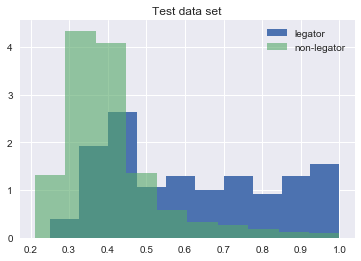

legators 278
non-legators 15377


In [77]:
plt.hist(test['prob_leg'][test.legatorflag==1], label = 'legator', normed=True, bins=10)
plt.hist(test['prob_leg'][test.legatorflag==0], label = 'non-legator',alpha=0.6, normed=True, bins=10)
plt.title('Test data set')
plt.legend()
plt.show()

print('legators', test['legatorflag'][test.legatorflag==1].count())
print('non-legators', test['legatorflag'][test.legatorflag==0].count())


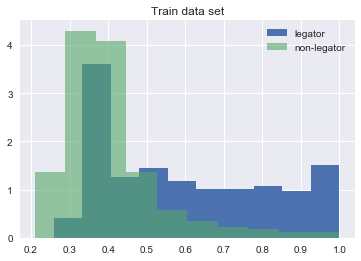

legators 1047
non-legators 61569


In [78]:
plt. 

plt.hist(train['prob_leg'][train.legatorflag==1], label = 'legator', normed=True, bins=10)
plt.hist(train['prob_leg'][train.legatorflag==0], label = 'non-legator',alpha=0.6, normed=True, bins=10)
plt.title('Train data set')
plt.legend()
plt.show()

print('legators', train['legatorflag'][train.legatorflag==1].count())
print('non-legators', train['legatorflag'][train.legatorflag==0].count())


The distribution of legacy probability is comparable across the train and test set.  

The distribution also highlights some flaws on the model - ideally most of your population should sit in a low probability bin, but most of these samples sit within 30-40% probability.  Over 50% probability is disportionately populated by the true/legator class which is reassuring.